In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tqdm import tqdm
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

import json

# 데이터 구성 및 모델 하이퍼파라메터 정의

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [40]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

SEED_NUM = 1234

q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

NameError: name 'seed' is not defined

In [41]:
tf.random.set_seed(SEED_NUM)

In [32]:
model_name = 'cnn_similarity'
BATCH_SIZE = 64
NUM_EPOCHS = 4
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'vocab_size': prepro_configs['vocab_size']+1,
         'word_embedding_dimension': 100,
         'conv_num_filters': 300,
         'conv_window_size': 3,
         'max_pool_seq_len': MAX_LEN,
         'sent_embedding_dimension': 128,
         'dropout_rate': 0.2,
         'hidden_dimension': 200,
         'output_dimension':1}

# 모델 구현

In [5]:
class SentenceEmbedding(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        self.conv = tf.keras.layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'], 
                                activation=tf.keras.activations.relu, 
                                padding='same')
        self.max_pool = tf.keras.layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = tf.keras.layers.Dense(kargs['sent_embedding_dimension'], 
                              activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

In [6]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__()
        
        self.word_embedding = tf.keras.layers.Embedding(kargs['vocab_size'], kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = tf.keras.layers.Dense(kargs['hidden_dimension'], 
                                           activation=tf.keras.activations.relu)
        self.logit = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        b_x = self.word_embedding(x[:, 0, :])
        h_x = self.word_embedding(x[:, 1, :])
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)
    
    def build_graph(self, input_shape):
        input_shape_wo_batch = input_shape[1:]
        self.build((input_shape[0], 2, input_shape[-1]))
        base = tf.keras.Input(shape=input_shape_wo_batch)
        hypothesis = tf.keras.Input(shape=input_shape_wo_batch)
        inputs = tf.stack([base, hypothesis], 1)
        
        _ = self.call(inputs)

In [31]:
model = SentenceSimilarityModel(**kargs)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.build_graph(input_shape=(BATCH_SIZE, MAX_LEN))
model.summary()

Model: "sentence_similarity_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 100)           7654700   
_________________________________________________________________
sentence_embedding_2 (Senten (None, 128)               128828    
_________________________________________________________________
sentence_embedding_3 (Senten (None, 128)               128828    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 7,963,957
Trainable params: 7,963,957
Non-trainable params: 0
_____________________________

## 모델 학습 및 평가

In [33]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=True)

history = model.fit(np.stack([q1_data, q2_data], 1), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

./data_out/cnn_similarity -- Folder create complete 

Train on 268673 samples, validate on 29853 samples
Epoch 1/4
268672/268673 [============================>.] - ETA: 0s - loss: 0.5610 - accuracy: 0.7080
Epoch 00001: saving model to ./data_out/cnn_similarity/weights.01-0.75.h5
268673/268673 [==============================] - 340s 1ms/sample - loss: 0.5610 - accuracy: 0.7080 - val_loss: 0.4979 - val_accuracy: 0.7473
Epoch 2/4
268672/268673 [============================>.] - ETA: 0s - loss: 0.4823 - accuracy: 0.7699
Epoch 00002: saving model to ./data_out/cnn_similarity/weights.02-0.71.h5
268673/268673 [==============================] - 314s 1ms/sample - loss: 0.4823 - accuracy: 0.7699 - val_loss: 0.5645 - val_accuracy: 0.7075
Epoch 3/4
268672/268673 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8004
Epoch 00003: saving model to ./data_out/cnn_similarity/weights.03-0.75.h5
268673/268673 [==============================] - 316s 1ms/sample - loss: 0.4312 - accura

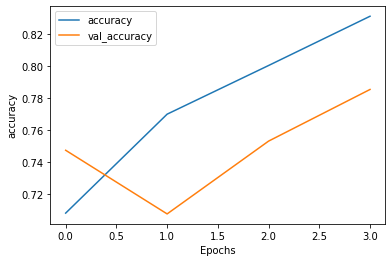

In [34]:
plot_graphs(history, 'accuracy')

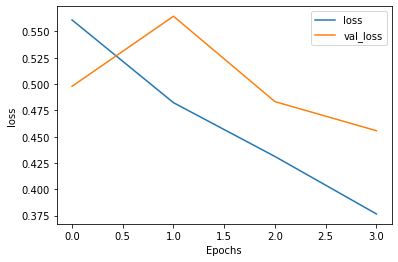

In [35]:
plot_graphs(history, 'loss')

## 캐글 데이터셋 준비 및 제출

In [36]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

SAVE_FILE_NM = 'weights.03-0.80.h5'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [37]:
BLOCK_SIZE = 500

predictions = [model(np.stack([test_q1_data[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE], \
                      test_q2_data[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE]], 1)).numpy() \
               for i in tqdm(range(test_q1_data.shape[0] // BLOCK_SIZE + 1))]


 14%|█▍        | 653/4692 [00:37<04:46, 14.10it/s]


 27%|██▋       | 1279/4692 [01:12<03:02, 18.75it/s]


 42%|████▏     | 1978/4692 [01:49<02:21, 19.24it/s]


 57%|█████▋    | 2653/4692 [02:24<01:51, 18.29it/s]


 71%|███████   | 3338/4692 [03:00<01:12, 18.76it/s]


 86%|████████▌ | 4040/4692 [03:37<00:34, 18.95it/s]


100%|██████████| 4692/4692 [04:11<00:00, 18.69it/s]


In [38]:
predictions = np.concatenate(predictions, axis=-2).squeeze(-1)

In [39]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv("cnn_predict.csv", index=False, quoting=3)

![alt text](images/cnn_result.png "Title") 